# Extraccion de caracteristicas apoyado en Vgg16 Entrenado en SVM

### Librerias comunes a todas las redes usadas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import random as python_random
from PIL import Image
from pathlib import Path
import seaborn as sns
import itertools
import joblib

### Librerias particulares en Keras

In [2]:
from __future__ import print_function, division
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from keras import models
from keras import layers
from keras import optimizers
import os
from tqdm import tqdm
import tensorflow as tf

### Fijar las semillas pseudoaleatorias para reproductibilidad de los modelos

In [3]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

### Variables generales

In [4]:
tamaño_imagen=150
IMG_SIZE = (tamaño_imagen, tamaño_imagen,3) #28
shape=[tamaño_imagen,tamaño_imagen,3]
epocas=10
modelo_nombre='svm'
umbral=0.5  # 0.5   Variar umbral cambia criterio Positivo o negativo
input_folder = 'dataset'  
output_folder= 'dividido'
modelos_folder='modelos/'
train_dir = output_folder+"/train"
val_dir = output_folder+"/val"
test_dir = output_folder+"/test"
ratio_entreno=0.8
ratio_val=0.1
ratio_test=0.1
colores='rgb' #  alternativa   colores='rgb'
batch_size = 32

In [5]:
#************************************

base_dir = 'dividido'
train_dir      = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir       = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(#rescale=1./255)
                             preprocessing_function=preprocess_input)
batch_size = 20

In [6]:
def cargar_ejemplos():
    P_image = Image.open(input_folder+'/P/0p.jpg')
    N_image = Image.open(input_folder+'/N/0n.jpg')
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.xlabel('P  (MonkeyPox)')
    plt.imshow(P_image)
    plt.subplot(1,2,2)
    plt.xlabel('N  (Sano)')
    plt.imshow(N_image)

In [7]:
def divide_dataset(origen,destino,entrena_ratio,val_ratio,test_ratio):
    if entrena_ratio+val_ratio+test_ratio==1:
         if not(Path(destino).is_dir()):
            splitfolders.ratio(origen, output= destino, seed=1337, ratio = (entrena_ratio,val_ratio,test_ratio))
    else:  
        print ("Error en los ratios, deben sumar 1")

In [8]:
def cambia_extension(path1):
    contador=0
    for dirs in os.listdir(path1):
        path2=path1+'/'+dirs
        for subdir in os.listdir(path2):
            path3=path2+'/'+subdir
            for files in os.listdir(path3):
                filename, extension = os.path.splitext(files)
                if extension==".jfif":
                    contador+=1
                    os.rename(path3+'/'+files, path3+'/'+filename+str(contador)+'.jpg')
    print("Se han cambiado las extensiones de: ", contador)

In [9]:
def guarda_modelo(modelo):
    modelo.save(modelos_folder+modelo_nombre+'.h5')
    print("Modelo guardado como: ",modelo_nombre+'.h5')

In [10]:
def guarda_history(modelo):
    df=pd.DataFrame(modelo.history)
    df.plot(figsize=(8,5))
    plt.show()
    df.to_csv(modelos_folder+modelo_nombre+'.csv', sep=';')
    print("History guardado como: ",modelo_nombre+'.csv')

In [11]:
def evalua_modelo(modelo):
    #Evaluacion del modelo
    scores=modelo.evaluate(train_features,train_labels,verbose=True)
    print("Precisión de entrenamiento: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(validation_features,validation_labels,verbose=True)
    print("Precisión de validacion: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(test_features,test_labels,batch_size=1,verbose=True)
    print("Precisión de prueba: %.1f%%\n"%(scores[1]*100))

In [12]:
def evalua2(modelo,test_features,test_labels):
    print("Generating confusion matrix")
    predictions = []
    targets = []
    yyy=modelo.predict(test_features)
    yyy=yyy.tolist()
    xxx=test_labels.tolist()
    predictions=[int(yyy[x]) for x in range(len(yyy))]
    targets=[int(xxx[x]) for x in range(len(xxx))]
    
    acsc=accuracy_score(targets, predictions)
    print('La precisión sobre el conjunto de test, es:',acsc)
    print('Las metricas principales son:')
    print(classification_report(targets, predictions, target_names=['N','P']))
    cm = confusion_matrix(targets, predictions)

    sns.heatmap(cm.astype("int"), annot=True,cmap='Blues')
    #Curva Roc
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curva')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return cm, acsc,predictions,targets

In [13]:
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Etiqueta')
    plt.xlabel('Predicha Etiqueta')
    plt.show()

In [14]:
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Etiqueta')
    plt.xlabel('Predicha Etiqueta')
    plt.show()

In [15]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  #recall = history.history['recall']
  #val_recall = history.history['val_recall']
    
  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

  '''# Plot recall
  plt.figure()
  plt.plot(epochs, accuracy, label='training_recall')
  plt.plot(epochs, val_accuracy, label='val_recall')
  plt.title('Recall')
  plt.xlabel('Epochs')
  plt.legend();'''

In [16]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred
def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [17]:
LOSS_METRICS = ['accuracy',recall]

In [18]:
def extract_features(directory, sample_count):
    '''
    Codificador de imagenes mediante conv_base en rasgos para
    posteriormente usarlos como datos para una red clasificadora densa
    
    parámetros
    directory      directorio con con los subdirectorios que definen clases
    sample_count   número de muestras a generar
    
    resultados
    conjunto de características y  etiquetas  
    '''
    # memoria para tensores con datos y etiquetas
    features  = np.zeros(shape=(sample_count, 4, 4, 512))
    labels    = np.zeros(shape=(sample_count))
    # instanciación del generador a partir del directorio donde estan las clases
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                            batch_size  = batch_size,
                                            class_mode  = 'binary')
    
    rango = list(range(int(sample_count/batch_size)))
    i = 0
    with tqdm(total=len(rango)) as pbar:
        for inputs_batch, labels_batch in tqdm(generator):
            # características predichas (codificadas) por la subred base
            # para las imágenes generadas (aumentadas) en lote
            features_batch = conv_base.predict(inputs_batch)
            # datos y etiquetas
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels  [i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1 
            if i * batch_size >= sample_count:
                # La ejecucion del generador debe terminarse explícitamente después 
                # usar todas la imágenes
                break
            pbar.update(1)
    
    return features, labels

# A - Tratamiento previo del dataset

### 1. Cargar imágenes 

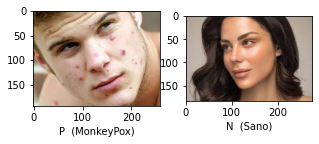

In [19]:
cargar_ejemplos()

###  2.- Dividir el dataset en entrenamiento + Validación + test <p>
Esta función lo hace, pero antes comprueba que no esté ya hecho, para no repetir el proceso.

In [20]:
divide_dataset(input_folder,output_folder,ratio_entreno, ratio_val, ratio_test)

### 3.- Corregir extensiones no compatible

El dataset original contiene ficheros con extensiones tipo '.jfif', que No son reconocidas por train_generator como imágenes<p>
Esta pequeña función renombra esas extensiones a jpg que sí son compatibles, de este modo operará con el dataset completo en número de imágenes disponibles

In [21]:
cambia_extension(output_folder)

Se han cambiado las extensiones de:  0


 ###  Antes  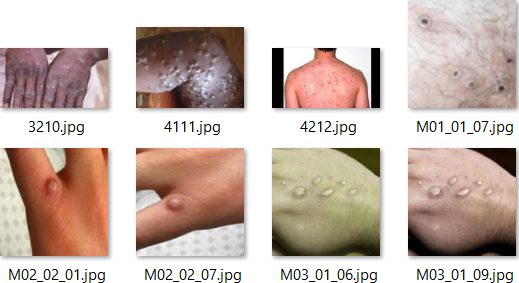

# Despues 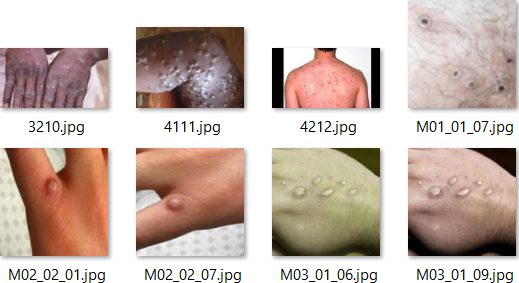

### 4.- Carga del modelo preentrenado usado para extraer características

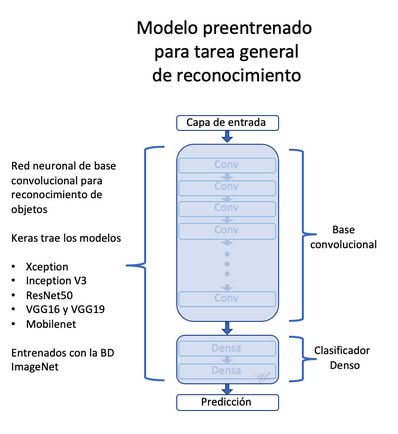

# Arquitectura Vgg-16

In [22]:
vgg16=None
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE)
                 )

### Extraer las caracteristicas de un tren de datos, con las mismas etiquetas de sus datos fuente

In [23]:
train_features, train_labels           = extract_features(train_dir,      3104)
validation_features, validation_labels = extract_features(validation_dir, 387)
test_features, test_labels             = extract_features(test_dir,       390)

Found 3104 images belonging to 2 classes.


100%|██████████| 155/155 [01:41<00:00,  1.43it/s]


100%|██████████| 155/155 [01:43<00:00,  1.49it/s]


Found 387 images belonging to 2 classes.


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Found 390 images belonging to 2 classes.


100%|██████████| 19/19 [00:15<00:00,  1.26it/s]


In [25]:
train_features      = np.reshape(train_features,      (3104, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (387, 4 * 4 * 512))
test_features       = np.reshape(test_features,       (390, 4 * 4 * 512))

### 5.- Modelar y entrenar el clasificador SVM

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(train_features,train_labels)

print('fitting done !!!')

fitting done !!!


### 6.- Evaluar modelo

Generar metricas

In [27]:
svm.score(train_features,train_labels)

0.9706829896907216

In [28]:
svm.score(validation_features,validation_labels)

0.9250645994832042

In [29]:
svm.score(test_features,test_labels)

0.9256410256410257

Generating confusion matrix
La precisión sobre el conjunto de test, es: 0.9256410256410257
Las metricas principales son:
              precision    recall  f1-score   support

           N       0.91      0.98      0.94       238
           P       0.96      0.84      0.90       152

    accuracy                           0.93       390
   macro avg       0.93      0.91      0.92       390
weighted avg       0.93      0.93      0.92       390



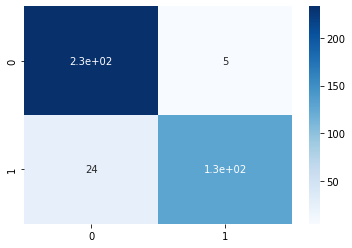

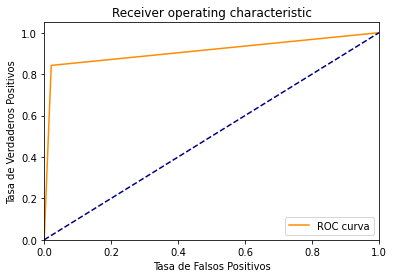

In [30]:
cm,ascs,predichos,reales=evalua2(svm,test_features,test_labels)

### matriz confusión en colores azules

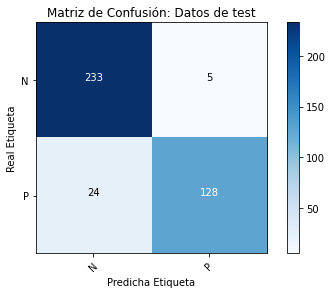

In [31]:
plot_confusion_matrix(cm, ['N','P'], title='Matriz de Confusión: Datos de test')

### Guardar modelo

In [32]:
joblib_file = modelos_folder + "svm_exfi.pkl"  
joblib.dump(svm, joblib_file)

['modelos/svm_exfi.pkl']

### Se ha guardado 1 modelo llamado svm_exfi